# Robot Controller 

Libraries

In [1]:
import time  
import json, math
from IPython.display import clear_output

import numpy as np
from numpy.linalg import inv
from scipy import stats
import matplotlib.pyplot as plt

 Controller setup

In [2]:
e = np.zeros((3,1));
ea = np.zeros((3,1));
lamda = 0.01

k1 = ( np.diag([1.1,2.3,1.3]));
k2 = (np.diag([1.2,2.3,3.3]));
k3 = ( np.diag([1.1,2.3,1.3]));

with open('data2.json', 'r') as fa:
                data = json.load(fa)
                
                k1[0,0] = data['controller']['k11']
                k1[1,1] = data['controller']['k12']
                k1[2,2] = data['controller']['k13']
                
                k2[0,0] = data['controller']['k21']
                k2[1,1] = data['controller']['k22']
                k2[2,2] = data['controller']['k23']
                
                k3[0,0] = data['controller']['k31']
                k3[1,1] = data['controller']['k32']
                k3[2,2] = data['controller']['k33']
                
                vmax = data['controller']['vmax']
                vmax2 = data['poss_obs']['vmax']
                T = data['poss']['T']
                
                xo_refr = data['poss_obs']['xref']
                yo_refr = data['poss_obs']['yref']
                zo_refr = data['poss_obs']['zref']
                
                dmin = data['poss_obs']['dmin']
                dmin2 = data['poss_obs']['dmin2']
                
                kd1 = data['poss_obs']['kd1']
                kd2 = data['poss_obs']['kd2']
                kd3 = data['poss_obs']['kd3']
                
                tau = data['poss_obs']['tau']
                
                kangle = data['poss_obs']['kangle']

State variables

In [3]:
P = np.array([0.2,0.2,0.2]).reshape(3,1);
Pp = np.zeros((3,1000));
P_obs = np.array([0.2,0.2,0.2]).reshape(3,1);
Po = np.array([2.1,2.1,10.1]).reshape(3,1);

Pa = np.zeros((3,1));  

V2 = np.zeros((3,1000));  
V = np.array([0.0,0.0,0.0]).reshape(3,1)

with open('bt2pointsb.json', 'r') as fa:
        data = json.load(fa)
        n_points = data['general']['n']
        n_counter = 1


Robot initial position

In [4]:
pose = [0.15,-0.43575, 0.35596]
xn = float(pose[0])
yn = float(pose[1])
zn = float(pose[2])

Obstacle Position

In [5]:
df = [0.5,-0.43575,0.36568]       
xo_refr = df[0] 
yo_refr = df[1]
zo_refr = df[2]     

Control Iteration

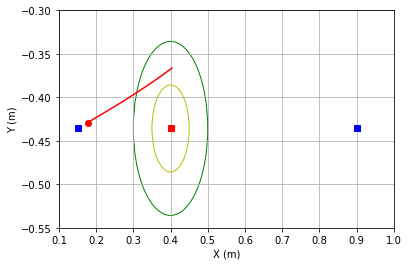

In [37]:
i=0
while i<400:
        i=i+1
        tic = time.clock()
        clear_output(wait=True)
        
        #Obstacle position
     
        P_obs[0,0] = float(xo_refr)
        P_obs[1,0] = float(yo_refr)
        P_obs[2,0] = float(zo_refr)

        
        #Robot Position n-1
        
        P[0,0] = float(xn)
        P[1,0] = float(yn)
        P[2,0] = float(zn)
                     
        
        #Desired  robot position
        if np.linalg.norm(e) < 0.01 :
            n_counter = n_counter + 1
            if n_counter > n_points :
                n_counter = 1
            
            with open('bt2pointsb.json', 'r') as fa:
                data = json.load(fa)
                n_points = data['general']['n']
                
                x_refr = data['position'+str(n_counter)]['xref']
                y_refr = data['position'+str(n_counter)]['yref']
                z_refr = data['position'+str(n_counter)]['zref']
                  
                Pa[0,0] = float(x_refr)
                Pa[1,0] = float(y_refr)
                Pa[2,0] = float(z_refr)
                
       
    #Distance between robot and obstacle
        ex = xo_refr-xn
        ey = yo_refr-yn
        ez = zo_refr-zn
        distance = round(math.sqrt(ex**2 + ey**2 + ez**2),4)

                
        #Controller calculation
        e = Pa - P
        hv = np.matmul(k2,np.tanh(np.matmul(k1,e) + np.matmul(k3,e-ea)))
        ea = e
        
        #Collision avoidance algorithm
        
        r_ao = P_obs - P
        n_r_ao = np.linalg.norm(r_ao)
        
        #First collision condition
        if n_r_ao < dmin and n_r_ao > dmin2:
            teta = np.arccos(np.matmul(r_ao.transpose(),e)/ (np.linalg.norm(r_ao)*np.linalg.norm(e)) )
            alfa = np.arccos(np.matmul(r_ao.transpose(),-P)/ (np.linalg.norm(r_ao)*np.linalg.norm(P)) ) 
            beta = np.arccos(np.matmul(e.transpose(),-P)/ (np.linalg.norm(P)*np.linalg.norm(e)) )

            #second collision condition
            if  teta < np.pi*kangle/180:
                nr = P / np.linalg.norm(P)
                nrg = e / np.linalg.norm(e)
                nv = V / np.linalg.norm(V)
                nro = r_ao / np.linalg.norm(r_ao)
                
                # SPEED    
                a = np.cross(nro.flatten(),nv.flatten())
                b = np.cross(a.flatten(),nro.flatten())
                b = b /np.linalg.norm(b)
                P_aux = np.zeros((3,1)) 
                P_aux[0,0] = -float(xn)
                P_aux[1,0] = -float(yn) 
                ang_aux = np.arccos(np.matmul(b,nr)/ (np.linalg.norm(nr)*np.linalg.norm(b)) )
                if ang_aux > np.pi/2 :
                    b = b
                else :
                    b = -b
  
                # AXIS Z
                a1 = np.cross(nro.flatten(),P_aux.flatten())
                b1 = np.cross(a1.flatten(),nro.flatten())
                b1 = b1 /np.linalg.norm(b1)
                ang_aux = np.arccos(np.matmul(b1,nr)/ (np.linalg.norm(nr)*np.linalg.norm(b1)) )

                             
                if ang_aux > np.pi/2 :
                    b1 = b1
                else :
                    b1 = -b1
                             
                             
                ur = r_ao/np.linalg.norm(r_ao)
                Fk = (1/(np.power(n_r_ao,3)))
                Fd = np.matmul(V.reshape([1,3]),ur.reshape([3,1]))
                Ft = kd1*b.reshape([3,1])*Fk + kd2*b1.reshape([3,1])*Fk - kd3*Fk*ur.reshape([3,1]) 

                vx1 = np.exp(-dmin*tau)*Ft[0,0] + (1-np.exp(-dmin*tau))*hv[0,0]
                vy1 = np.exp(-dmin*tau)*Ft[1,0] + (1-np.exp(-dmin*tau))*hv[1,0]
                vz1 = np.exp(-dmin*tau)*Ft[2,0] + (1-np.exp(-dmin*tau))*hv[2,0]
                             
            else: 
                             
                ur = r_ao/np.linalg.norm(r_ao)
                Fk = (1/(np.power(n_r_ao,3)))
                Ft = - kd3*Fk*ur.reshape([3,1]) 
                             
                vx1 = 0.8*np.exp(-dmin*tau)*hv[0,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[0,0]
                vy1 = 0.8*np.exp(-dmin*tau)*hv[1,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[1,0]
                vz1 = 0.8*np.exp(-dmin*tau)*hv[2,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[2,0]
        
        elif n_r_ao < dmin2:
                             
            vx1 = 0
            vy1 = 0
            vz1 = 0
            
            
            while n_r_ao < dmin2+0.01:            
                      
                P_obs[0,0] = float(xo_refr)
                P_obs[1,0] = float(yo_refr)
                P_obs[2,0] = float(zo_refr)

                r_ao = P_obs - P
                n_r_ao = np.linalg.norm(r_ao)

        else :
            vx1 = hv[0,0]
            vy1 = hv[1,0]
            vz1 = hv[2,0]
        
        
        #Speed limits
        VMAX = np.sqrt(vx1*vx1+vy1*vy1+vz1*vz1) 
        
        if (VMAX > vmax):
            vx1 = vx1*vmax/VMAX
            vy1 = vy1*vmax/VMAX
            vz1 = vz1*vmax/VMAX

#Update velocity vector                             
        V[0,0] = vx1
        V[1,0] = vy1
        V[2,0] = vz1
        
        V2[0,i] = vx1
        V2[1,i] = vy1
        V2[2,i] = vz1
        
        #  Update position robot
        sample_time=time.clock()-tic
        xn = float(xn+vx1*0.05)
        yn = float(yn+vy1*0.05)
        zn = float(zn+vz1*0.05)
      
        Pp[0,i] = float(xn)
        Pp[1,i] = float(yn)
        Pp[2,i] = float(zn)
        
        
        #Plot trajectory
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
        ax.plot(Pp[0,(i-40):i+1], Pp[1,(i-40):i+1], 'r')  #plot 4o last points    
        ax.plot(xn, yn, 'ro')   #plot last position
        ax.plot(0.15, y_refr, 'bs',0.9, y_refr, 'bs') #plot target points
        ax.plot(xo_refr,yo_refr,'rs')  #plot obstacle
        
        #plot potential field
        circle1 =plt.Circle((xo_refr,yo_refr), dmin, color='g', fill=False)  
        circle2 =plt.Circle((xo_refr,yo_refr), dmin2, color='y', fill=False)  
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.axis([0.1, 1, -0.55, -0.3])
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(which='both')
        plt.show()
        
        
        time.sleep(0.001)
    

# Exercise 1

Modify the obstacle position (axis x or y) and run the simulation

In [19]:
# %load scripts/obstacle_position.py
df = [0.4,-0.43575,0.36568]       
xo_refr = df[0] 
yo_refr = df[1]
zo_refr = df[2]   

In [20]:
# %load scripts/control.py
i=0
while i<500:
        i=i+1
        tic = time.clock()
        clear_output(wait=True)
        
        #Obstacle position
     
        P_obs[0,0] = float(xo_refr)
        P_obs[1,0] = float(yo_refr)
        P_obs[2,0] = float(zo_refr)

        
        #Robot Position n-1
        
        P[0,0] = float(xn)
        P[1,0] = float(yn)
        P[2,0] = float(zn)
                     
        
        #Desired  robot position
        if np.linalg.norm(e) < 0.01 :
            n_counter = n_counter + 1
            if n_counter > n_points :
                n_counter = 1
            
            with open('bt2pointsb.json', 'r') as fa:
                data = json.load(fa)
                n_points = data['general']['n']
                
                x_refr = data['position'+str(n_counter)]['xref']
                y_refr = data['position'+str(n_counter)]['yref']
                z_refr = data['position'+str(n_counter)]['zref']
                  
                Pa[0,0] = float(x_refr)
                Pa[1,0] = float(y_refr)
                Pa[2,0] = float(z_refr)
                
       
    #Distance between robot and obstacle
        ex = xo_refr-xn
        ey = yo_refr-yn
        ez = zo_refr-zn
        distance = round(math.sqrt(ex**2 + ey**2 + ez**2),4)

                
        #Controller calculation
        e = Pa - P
        hv = np.matmul(k2,np.tanh(np.matmul(k1,e) + np.matmul(k3,e-ea)))
        ea = e
        
        #Collision avoidance algorithm
        
        r_ao = P_obs - P
        n_r_ao = np.linalg.norm(r_ao)
        
        #First collision condition
        if n_r_ao < dmin and n_r_ao > dmin2:
            teta = np.arccos(np.matmul(r_ao.transpose(),e)/ (np.linalg.norm(r_ao)*np.linalg.norm(e)) )
            alfa = np.arccos(np.matmul(r_ao.transpose(),-P)/ (np.linalg.norm(r_ao)*np.linalg.norm(P)) ) 
            beta = np.arccos(np.matmul(e.transpose(),-P)/ (np.linalg.norm(P)*np.linalg.norm(e)) )

            #second collision condition
            if  teta < np.pi*kangle/180:
                nr = P / np.linalg.norm(P)
                nrg = e / np.linalg.norm(e)
                nv = V / np.linalg.norm(V)
                nro = r_ao / np.linalg.norm(r_ao)
                
                # SPEED    
                a = np.cross(nro.flatten(),nv.flatten())
                b = np.cross(a.flatten(),nro.flatten())
                b = b /np.linalg.norm(b)
                P_aux = np.zeros((3,1)) 
                P_aux[0,0] = -float(xn)
                P_aux[1,0] = -float(yn) 
                ang_aux = np.arccos(np.matmul(b,nr)/ (np.linalg.norm(nr)*np.linalg.norm(b)) )
                if ang_aux > np.pi/2 :
                    b = b
                else :
                    b = -b
  
                # AXIS Z
                a1 = np.cross(nro.flatten(),P_aux.flatten())
                b1 = np.cross(a1.flatten(),nro.flatten())
                b1 = b1 /np.linalg.norm(b1)
                ang_aux = np.arccos(np.matmul(b1,nr)/ (np.linalg.norm(nr)*np.linalg.norm(b1)) )

                             
                if ang_aux > np.pi/2 :
                    b1 = b1
                else :
                    b1 = -b1
                             
                             
                ur = r_ao/np.linalg.norm(r_ao)
                Fk = (1/(np.power(n_r_ao,3)))
                Fd = np.matmul(V.reshape([1,3]),ur.reshape([3,1]))
                Ft = kd1*b.reshape([3,1])*Fk + kd2*b1.reshape([3,1])*Fk - kd3*Fk*ur.reshape([3,1]) 

                vx1 = np.exp(-dmin*tau)*Ft[0,0] + (1-np.exp(-dmin*tau))*hv[0,0]
                vy1 = np.exp(-dmin*tau)*Ft[1,0] + (1-np.exp(-dmin*tau))*hv[1,0]
                vz1 = np.exp(-dmin*tau)*Ft[2,0] + (1-np.exp(-dmin*tau))*hv[2,0]
                             
            else: 
                             
                ur = r_ao/np.linalg.norm(r_ao)
                Fk = (1/(np.power(n_r_ao,3)))
                Ft = - kd3*Fk*ur.reshape([3,1]) 
                             
                vx1 = 0.8*np.exp(-dmin*tau)*hv[0,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[0,0]
                vy1 = 0.8*np.exp(-dmin*tau)*hv[1,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[1,0]
                vz1 = 0.8*np.exp(-dmin*tau)*hv[2,0] + 1.2*(1-np.exp(-dmin*tau))*Ft[2,0]
        
        elif n_r_ao < dmin2:
                             
            vx1 = 0
            vy1 = 0
            vz1 = 0
            
            
            while n_r_ao < dmin2+0.01:            
                      
                P_obs[0,0] = float(xo_refr)
                P_obs[1,0] = float(yo_refr)
                P_obs[2,0] = float(zo_refr)

                r_ao = P_obs - P
                n_r_ao = np.linalg.norm(r_ao)

        else :
            vx1 = hv[0,0]
            vy1 = hv[1,0]
            vz1 = hv[2,0]
        
        
        #Speed limits
        VMAX = np.sqrt(vx1*vx1+vy1*vy1+vz1*vz1) 
        
        if (VMAX > vmax):
            vx1 = vx1*vmax/VMAX
            vy1 = vy1*vmax/VMAX
            vz1 = vz1*vmax/VMAX

#Update velocity vector                             
        V[0,0] = vx1
        V[1,0] = vy1
        V[2,0] = vz1
        
        V2[0,i] = vx1
        V2[1,i] = vy1
        V2[2,i] = vz1
        
        #  Update position robot
        sample_time=time.clock()-tic
        xn = float(xn+vx1*0.05)
        yn = float(yn+vy1*0.05)
        zn = float(zn+vz1*0.05)
      
        Pp[0,i] = float(xn)
        Pp[1,i] = float(yn)
        Pp[2,i] = float(zn)
        
        
        
        time.sleep(0.001)
    

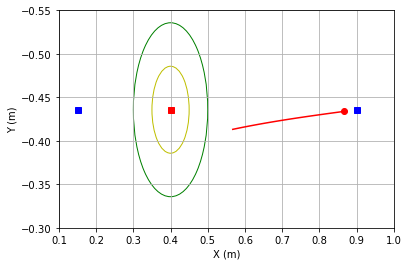

In [26]:
# %load scripts/plot_system_simple.py
i=0
for i in range(500):
    #Plot trajectory
        clear_output(wait=True)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
        if i>40:
            ax.plot(Pp[0,(i-40):i+1], Pp[1,(i-40):i+1], 'r')  #plot 4o last points   
        else:
            ax.plot(Pp[0,0:i+1], Pp[1,0:i+1], 'r')  #plot 4o last points
        
        ax.plot(Pp[0,i], Pp[1,i], 'ro')   #plot last position
        ax.plot(0.15, y_refr, 'bs',0.9, y_refr, 'bs') #plot target points
        ax.plot(xo_refr,yo_refr,'rs')  #plot obstacle
        circle1 =plt.Circle((xo_refr,yo_refr), dmin, color='g', fill=False)  #plot inverse potential field
        circle2 =plt.Circle((xo_refr,yo_refr), dmin2, color='y', fill=False)  #plot inverse potential field
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.axis([0.1, 1, -0.55, -0.3])
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(which='both')
        

        plt.show()

# Exercise 2

Modify the initial position of the robot 

In [38]:
%load scripts/robot_position.py

In [39]:
%load scripts/control.py

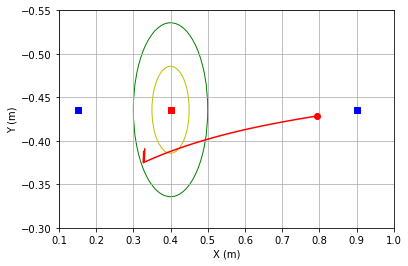

In [40]:
%load scripts/plot_system_simple.py

# Exercise 3

Plot robot position axis x and y as subplots in the simulation

In [ ]:
%load scripts/plot_system_simple.py

In [ ]:
%load scripts/control.py

In [ ]:
%load scripts/plot_system.py